In [19]:
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from os.path import join

(158, 158, 3)

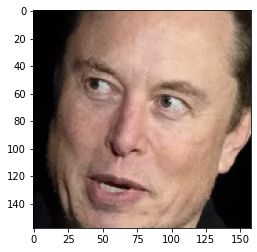

In [21]:



img = cv2.imread('cropped\elonmusk\elonmusk1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img.shape

In [22]:
import pywt


def w2d(img, mode = 'haar', level = 1):
    img_array = img
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    img_array = np.float32(img_array)
    img_array /= 255
    coeff = pywt.wavedec2(img_array, mode, level=level)
    # print(coeff)
    coeff = list(coeff)
    coeff[0] *= 0
    img_array_h = pywt.waverec2(coeff, mode)
    img_array_h *= 255
    img_array_h = np.uint8(img_array_h)

    return img_array_h







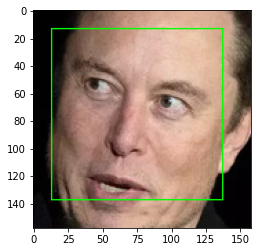

In [24]:
eye_cascade = cv2.CascadeClassifier('opencv\haarcascade_eye.xml')
face_cascade = cv2.CascadeClassifier('opencv\haarcascade_frontalface_default.xml')
face = face_cascade.detectMultiScale(img, 1.3, 5)
x, y, w, h = face[0]
eye = eye_cascade.detectMultiScale(img, 1.3, 5)
img_rect = img.copy()
img_rect = cv2.rectangle(img_rect, (x, y), (x+w, y+h), (0, 255, 0))
if(len(eye)>=2):
    x, y, w, h = eye[0]
    img_rect = cv2.rectangle(img_rect, (x, y), (x+w, y+h), (0, 255, 0))
    x, y, w, h = eye[1]
    img_rect = cv2.rectangle(img_rect, (x, y), (x+w, y+h), (0, 255, 0))
plt.imshow(img_rect)

In [26]:
import os
import shutil
#make sure your data is stored in a folder named "celebrity_faces" in order for this to work

def have_2_eyes(img_path):
    img = cv2.imread(img_path)

    eye = eye_cascade.detectMultiScale(img, 1.3, 5)
    face = face_cascade.detectMultiScale(img, 1.3, 5)
    if(len(eye)>=2 and len(face)):
        return True
    return False
    
#give your own data path
celeb_names = os.listdir('celebrity_faces')
if(os.path.exists('cropped')):
    shutil.rmtree('cropped')

os.mkdir('cropped')

for i in celeb_names:
    os.mkdir(os.path.join('cropped', i))
    
raw_train_data_path = 'celebrity_faces'
cropped_data_path = 'cropped'
for i in celeb_names:
    data = os.listdir(os.path.join(raw_train_data_path, i))
    data = [os.path.join(raw_train_data_path, i, x) for x in data]
    for c, img_path in enumerate(data, start = 1):
        img = cv2.imread(img_path)
  
        if(have_2_eyes(img_path)):
            img = cv2.imread(img_path)
            face = face_cascade.detectMultiScale(img, 1.3, 5)
            if(len(face)==1):
                x, y, w, h = face[0]
            
                cropped_img = img[y: y+h, x: x+w]
                filename = i+str(c)+'.png'
                cv2.imwrite(os.path.join(cropped_data_path,i,filename), cropped_img)



In [106]:
class_dict = {}
cnt = 0
for i in os.listdir('celebrity_faces'):
    class_dict[i] = cnt
    cnt+=1

In [27]:
X, y = [], []

for indx, name in enumerate(celeb_names):
    for file in os.listdir(os.path.join(cropped_data_path, name)):
        full_path = os.path.join(cropped_data_path, name, file)
        img = cv2.imread(full_path)
        img_wavelet = w2d(img, 'db1', 5)
        img = cv2.resize(img, (32, 32))
        img_wavelet = cv2.resize(img_wavelet, (32, 32))
        # print(img_wavelet.shape)
        img = img.reshape(32*32*3, 1)
        img_wavelet = img_wavelet.reshape(32*32, 1)
        X.append(np.vstack((img, img_wavelet)))
        y.append(indx)
        

In [28]:
X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape

(161, 4096)

In [29]:

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C=10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)





0.6829268292682927

In [30]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.42      0.56        12
           1       0.52      1.00      0.69        11
           2       0.83      0.91      0.87        11
           3       0.00      0.00      0.00         4
           4       1.00      0.67      0.80         3

    accuracy                           0.68        41
   macro avg       0.64      0.60      0.58        41
weighted avg       0.68      0.68      0.64        41



C:\Users\jay\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jay\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jay\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [31]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [90]:
model_params = {
    'svm' : {
        'model' : svm.SVC(gamma='auto', probability=True),
        'params': {
            'svc__C': [1, 10, 50, 100, 500, 1000], 
            'svc__kernel': ['linear', 'rbf']
        } 
        
    },
    'random_forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators' : [1, 5, 10, 15, 20, 25]
        }
    },
    'logistic_regression':{
        'model' : LogisticRegression(solver='liblinear', multi_class='auto'),
        'params' : {
            'logisticregression__C': [1, 5, 10, 15, 20, 25]
        }
    }
}

In [91]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv = 5, return_train_score=False)
    # print(clf)
    clf.fit(X_train, y_train)
    scores.append({
        'model' : algo, 
        'best_score' : clf.best_score_, 
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    df = pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])
display(df)

,model,best_score,best_params
0,svm,0.783333,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.633333,{'randomforestclassifier__n_estimators': 20}
2,logistic_regression,0.750000,{'logisticregression__C': 1}


In [77]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [92]:
best_estimators['svm'].score(X_test, y_test)

0.8292682926829268

In [93]:
best_estimators['random_forest'].score(X_test, y_test)

0.5853658536585366

In [94]:
best_estimators['logistic_regression'].score(X_test, y_test)

0.9024390243902439

In [95]:
best_clf = best_estimators['logistic_regression']

In [96]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm 

array([[10,  1,  0,  1,  0],
       [ 0, 10,  0,  1,  0],
       [ 0,  0, 10,  0,  1],
       [ 0,  0,  0,  4,  0],
       [ 0,  0,  0,  0,  3]], dtype=int64)

Text(69.0, 0.5, 'Truth')

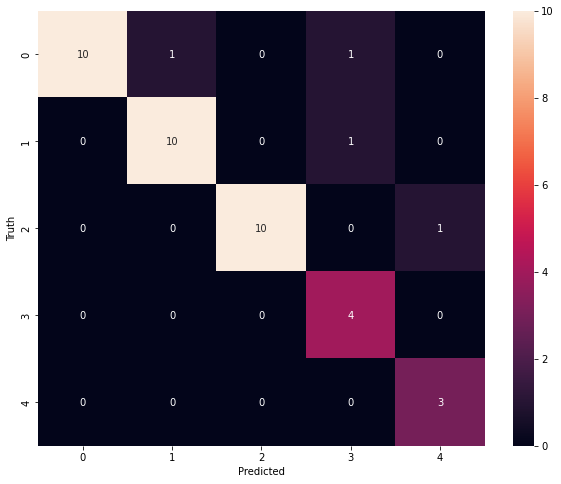

In [104]:
import seaborn as sn
plt.figure(figsize=(10, 8))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [107]:
class_dict

{'elonmusk': 0,
 'markzuckerberg': 1,
 'mukesh ambani': 2,
 'stevejobs': 3,
 'sundarpichai': 4}

In [108]:
import joblib as jlb
jlb.dump(best_clf, "detection_model.pkl")

['detection_model.pkl']

In [110]:
import json
with open('class_dictonary.json', 'w') as f:
    json.dump(class_dict, f)
    